In [7]:
# Olivia Laske
# Version as of July 25, 2023
# Imports
import astropy.units as u
import astropy.constants as constants
import bilby
import math
import matplotlib.pyplot as plt
import numpy as np
from pygwb.detector import Interferometer
from pygwb.network import Network
from pygwb.simulator import Simulator
import scipy

In [8]:
import matplotlib 
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
fontsize = 9
# ALWAYS USE figsize = (3.375, X) for column plots 
# figsize = (6.75, X) for rows 
params = {
   'axes.labelsize': fontsize,
   'font.size': fontsize,
   'legend.fontsize': 8,
   'xtick.labelsize': fontsize,
   'ytick.labelsize': fontsize,
   'axes.titlesize':fontsize,
   'lines.linewidth':1,  
   'xtick.direction':'in',
   'ytick.direction':'in',
#    'text.usetex': True,
   'font.family':'Serif',
   'font.serif':'Hoefler Text',
   'axes.grid':True,
   'figure.figsize': (6.75, 4),
   'figure.dpi':250,
   'mathtext.fontset':'cm'
}

for param in params.keys():
    matplotlib.rcParams[param] = params[param]    

$$\rho_\text{c}=\frac{3H_0^2}{8\pi G}$$

In [9]:
def p_c(H0):
    '''
    Equation from Renzini et al. 2022.
    Calculates the critical energy density.
    
    Parameters
    ----------
    H0 : double
        Hubble constant
        
    Returns
    -------
    double
        critical energy density
    '''
    G = 6.6743015e-11 # Gravitational constant, in m^3 kg^-1 s^-2
    return ((3*(H0**2))/(8*math.pi*G))

$$\dot{N}(z)=\mathcal{C}(\alpha,\beta,z_\text{p})\frac{\dot{N}_0(1+z)^\alpha}{1+(\frac{1+z}{1+z_\text{p}})^{\alpha+\beta}}$$

In [10]:
def R(alpha, beta, z, z_p, R0):
    '''
    Equation from Callister et al. 2020.
    Calculates the merger rate at a given redshift.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z : double
        redshift
    z_p : double
        peak redshift of merger rate
    R0 : double
        current merger rate (z = 0)
        
    Returns
    -------
    double
        merger rate at the given redshift
    '''
    return (C(alpha, beta, z_p)*((R0*((1+z)**alpha))/(1+(((1+z)/(1+z_p))**(alpha+beta)))))

$$\mathcal{C}(\alpha,\beta,z_\text{p})=1+(1+z_\text{p})^{-(\alpha+\beta)}$$

In [11]:
def C(alpha, beta, z_p):
    '''
    Equation from Callister et al. 2020.
    Calculates the normalization constant for the merger rate.
    
    Parameters
    ----------
    alpha : double
        spectral index before peak z_p
    beta : double
        spectral index after peak z_p
    z_p : double
        peak redshift of merger rate
    
    Returns
    -------
    double
        normalization constant for the merger rate
    '''
    return (1+((1+z_p)**(-alpha-beta)))

$$H(z)=H_0(\Omega_\text{R}(1+z)^4+\Omega_\text{M}(1+z)^3+\Omega_\text{k}(1+z)^2+\Omega_\Lambda)^{1/2}$$

In [12]:
def Hubble_rate(z, H0, omega_R, omega_M, omega_k, omega_lambda):
    '''
    Equation from Renzini et al. 2022.
    Calculates the Hubble rate as a function of redshift.
    
    Parameters
    ----------
    z : double
        redshift
    H0 : double
        Hubble constant (Hubble rate at z = 0)
    omega_R : double
        radiation component of energy density
    omega_M : double
        matter component of energy density
    omega_k : double
        spacetime curvature component of energy density
    omega_lambda : double
        dark energy component of energy density, cosmological constant
    
    Returns
    -------
    double
        Hubble rate for a given redshift z
    '''
    return H0*(((omega_R*((1+z)**4))+(omega_M*((1+z)**3))+(omega_k*((1+z)**2))+omega_lambda)**(1/2))

$$\bigg\langle\frac{dE_\text{GW}}{df_\text{r}}\bigg\rangle=\int d\theta p(\theta)\frac{dE_\text{GW}(\theta;f_\text{r})}{df_\text{r}}$$

In [13]:
def ave_dE_df(f, Mtots, events):
    '''
    Equation from Renzini et al. 2022.
    Sums the spectral energy density of individual events with a given set of parameters.
    
    Parameters
    ----------
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring
    events : List<double>
        list of events that incorporates the mass distribution
        
    Returns
    -------
    double
        average spectral density
    '''
    total_sum = 0
    for i in range(len(events)):
        Mtot = Mtots[i]
        M = events[i]
        value = dE_df(M, f, Mtot)
        total_sum += value
    return total_sum

$$\frac{dE_\text{GW}}{df}=\frac{(G\pi)^{2/3}\mathcal{M}^{5/3}}{3}H(f)$$

In [14]:
def dE_df(M, f, Mtot):
    '''
    Equation from Callister et al. 2016.
    Calculates the spectral energy density for a single event.
    
    Parameters
    ----------
    M : double
        chirp mass
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring
        
    Returns
    -------
    double
        spectral energy density for a given chirp mass and frequency
    '''
    G = 6.6743015e-11 # Gravitational constant, in m^3 kg^-1 s^-2
    return ((((G*math.pi)**(2/3))*(M**(5/3))*H(f, Mtot))/3)

$$H(f)=
\begin{cases}
    f^{-1/3} && (f<f_\text{merge}) \\
    \frac{f^{2/3}}{f_\text{merge}} && (f_\text{merge}\leq f<f_\text{ring}) \\
    \frac{1}{f_\text{merge}f_\text{ring}^{4/3}}\bigg(\frac{f}{1+(\frac{f-f_\text{ring}}{\sigma/2})^2}\bigg)^2 && (f_\text{ring} \leq f<f_\text{cutoff}) \\
    0 && (f\geq f_\text{cutoff})
\end{cases}
$$

In [15]:
def H(f, Mtot):
    '''
    Equation from Callister et al. 2016.
    Calculates H for a given frequency.
    
    Parameters
    ----------
    f : double
        frequency (in Hz)
    f_merge : double
        merger frequency (in Hz)
    f_ring : double
        ringdown frequency (in Hz)
    f_cutoff : double
        cutoff frequency (in Hz)
    sigma : double
        width of Lorentzian function around f_ring
        
    Returns
    -------
    double
        H(f)
    '''
    # Parameters from Tom Callister
    # Waveform model from Ajith+ 2008 (10.1103/PhysRevD.77.104017)
    # Define IMR parameters
    # See Eq. 4.19 and Table 1
    G = 6.6743015e-11 # Gravitational constant, in m^3 kg^-1 s^-2
    c = 2.998e8 # Speed of light, in m/s
    eta = 0.25
    Msun = 1.99e30
    MsunToSec = Msun*G/np.power(c,3.)
       
    f_merge = (0.29740*eta**2. + 0.044810*eta + 0.095560)/(np.pi*Mtot*MsunToSec)
    f_ring = (0.59411*eta**2. + 0.089794*eta + 0.19111)/(np.pi*Mtot*MsunToSec)
    f_cutoff = (0.84845*eta**2. + 0.12828*eta + 0.27299)/(np.pi*Mtot*MsunToSec)
    sigma = (0.50801*eta**2. + 0.077515*eta + 0.022369)/(np.pi*Mtot*MsunToSec)
    
    if f < f_merge:
        return (f**(-1/3))
    elif f >= f_merge and f < f_ring:
        return ((f**(2/3))/f_merge)
    elif f >= f_ring and f < f_cutoff:
        return ((1/(f_merge*(f_ring**(4/3))))*((f/(1+(((f-f_ring)/(sigma/2))**2)))**2))
    else:
        return 0

In [16]:
from bilby.gw.prior import Cosmological
# Define redshift prior
class PowerLawRedshiftPrior(Cosmological):
    def __init__(self, minimum, maximum, R0, alpha, beta, zp, **kwargs):
        """
        R0 is in units of Gpc^{-3} yr^{-1}
        """
        self.R0 = R0 * 1e-9 # convert to Mpc^{-3} yr^{-1}
        self.alpha = alpha
        self.beta = beta
        self.zp = zp
        super(PowerLawRedshiftPrior, self).__init__(minimum=minimum, maximum=maximum, **kwargs)
        
    def _get_redshift_arrays(self):
        zs = np.linspace(self._minimum['redshift'] * 0.99,
                         self._maximum['redshift'] * 1.01, 1000)
        C = 1 + (1 + self.zp)**(-self.alpha - self.beta)
        p_dz = (1/(1+zs)) * C * ((self.R0 * (1 + zs)**(self.alpha))/(1 + ((1 + zs)/(1 + self.zp))**(self.alpha + self.beta))) * 4 * np.pi * self.cosmology.differential_comoving_volume(zs)
        return zs, p_dz

$$\Omega_\text{GW}=\frac{f}{\rho_\text{c}}\int_0^{z_\text{max}}dz\frac{\dot{N}(z)}{(1+z)H(z)}\bigg\langle\frac{dE_\text{GW}}{df_\text{r}}\bigg |_{f_\text{r}=f(1+z)}\bigg\rangle$$

In [17]:
# Method adapted from Callister et al. 2020 and Renzini et al. 2022
# Generate List of Events

# Define Parameters
alpha = 1.9 # spectral index before peak z_p
beta = 3.4 # spectral index after peak z_p
z_p = 2.4 # peak redshift of merger rate

R0 = 28.3 # current merger rate

z_max = 10 # maximum plausible redshift

H0 = 67.4 # Hubble constant (Hubble rate at z = 0), in km/s/Mpc
omega_R = 9.182e-5 # radiation component of energy density
omega_M = 0.3111 # matter component of energy density
omega_k = 0 # spacetime curvature component of energy density
omega_lambda = 0.6889 # dark energy component of energy density, cosmological constant

# Create injections
T_obs = (1/365.25/24) # in yrs
duration = T_obs*60*60*24*365.25 # Duration of each segment of data [s]
N_segs = 1 # number of data segments to generate
sampling_frequency = 1024 # Hz

priors = bilby.gw.prior.BBHPriorDict(aligned_spin=True)
# priors['mass_1'] = bilby.core.prior.LogUniform(5,50)
# priors['mass_2'] = bilby.core.prior.Uniform(5,50)
priors['mass_1'] = bilby.core.prior.PowerLaw(alpha=-2.3, minimum=5, maximum=50)
priors['mass_ratio'] = bilby.core.prior.PowerLaw(alpha=1.5, minimum=0, maximum=1)
priors['theta_jn'] = bilby.core.prior.Uniform(0, 2*np.pi, name='theta_jn')
priors['chi_1'] = 0
priors['chi_2'] = 0
priors['redshift'] = PowerLawRedshiftPrior(R0=R0, alpha=alpha, beta=beta, zp=z_p, name='redshift', minimum=0, maximum=10)

# Calculate number of injections    
zs, p_dz = priors['redshift']._get_redshift_arrays()
p_dz_centers = (p_dz[1:] + p_dz[:-1])/2.
total_sum = np.sum(np.diff(zs) * p_dz_centers)
N = T_obs * total_sum
N_inj = np.random.poisson(N.value)
injections = priors.sample(N_inj)

# events = injections['chirp_mass']
mass_2 = []
Mtots = []
events = []
for i in range(len(injections['mass_1'])):
    mass_2.append(injections['mass_1'][i]*injections['mass_ratio'][i])
    Mtots.append(injections['mass_1'][i]+mass_2[i])
    events.append(((injections['mass_1'][i]*mass_2[i])**(3/5))/((injections['mass_1'][i]+mass_2[i])**(1/5)))
#     Mtots.append(injections['mass_1'][i]+injections['mass_2'][i])

frequencies = []
omega_GW_values = []

for i in range(1,sampling_frequency):
    f = i # frequency (in Hz)
    
    # Equation from Renzini et al. 2022.
    # Calculate the GW energy density by summing the spectral energy density from individual BBH events across redshift space.
    def integrand(z):
        f_ref = f*(1+z)
        return ((R(alpha, beta, z, z_p, R0)/((1+z)*Hubble_rate(z, H0, omega_R, omega_M, omega_k, omega_lambda)))*ave_dE_df(f_ref, Mtots, events))

    integral = scipy.integrate.quad(integrand, 0, z_max)
    omega_GW = ((f/p_c(H0))*integral[0]*386412.809777)
    frequencies.append(f)
    omega_GW_values.append(omega_GW)

09:53 bilby INFO    : Using aligned spin prior
09:53 bilby INFO    : No prior given, using default BBH priors in /Users/olivialaske/opt/anaconda3/envs/igwn-py39-lw/lib/python3.9/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


/var/folders/ll/kr0d3dk97nscjzcx85rrjmz00000gn/T/ipykernel_34719/4069751248.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


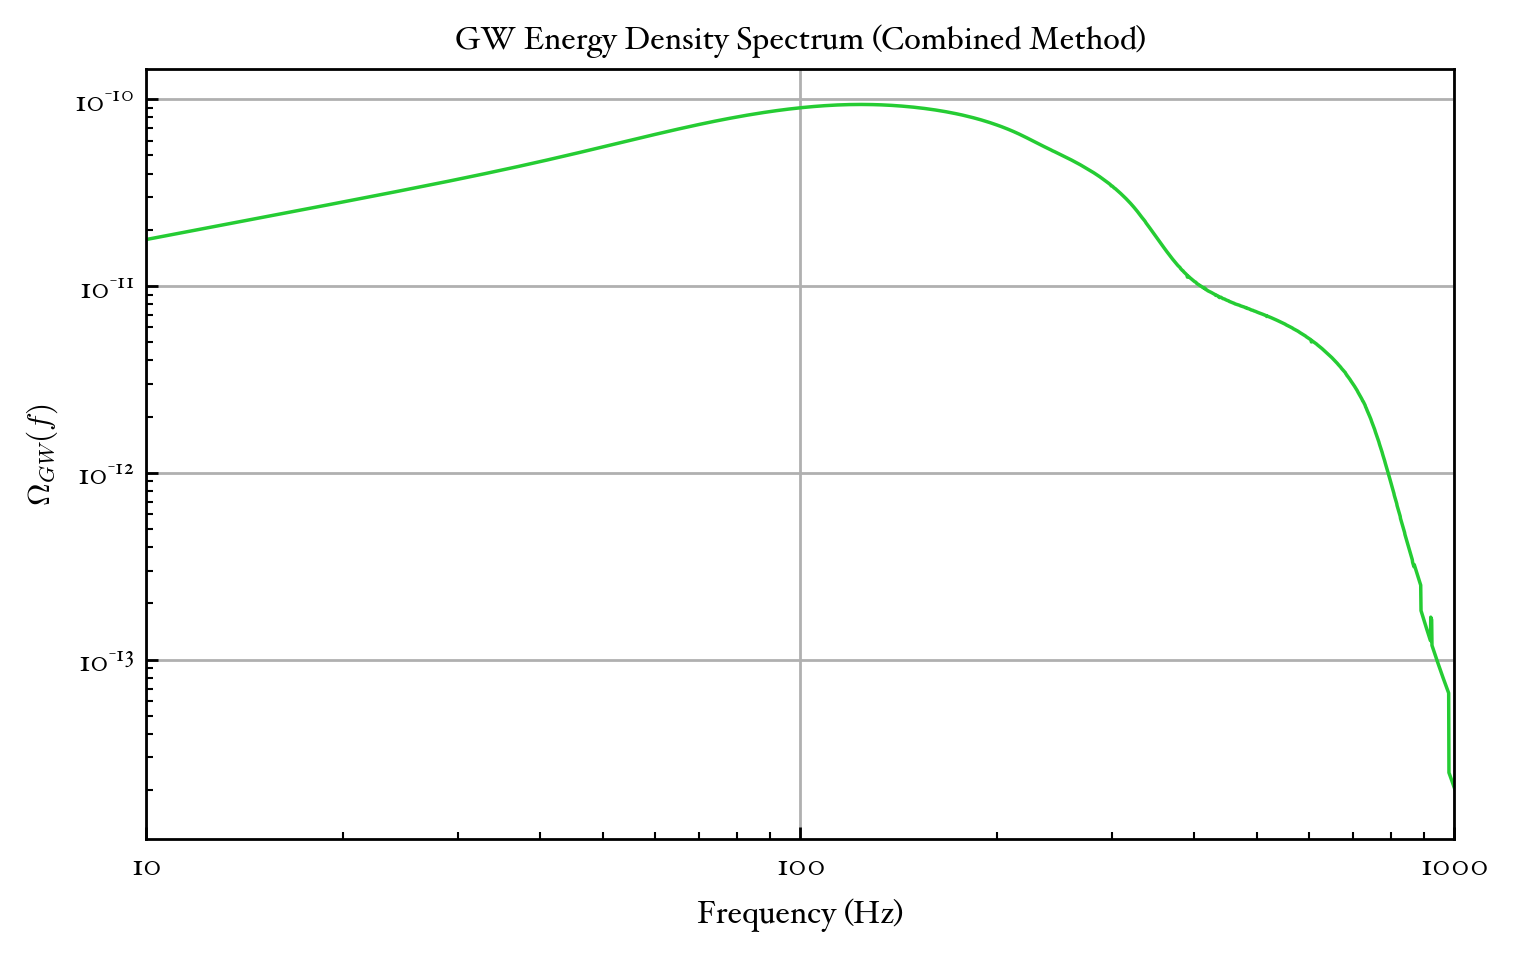

In [18]:
fig, ax = plt.subplots()
ax.set_title(r'GW Energy Density Spectrum (Combined Method)')
ax.set_xlabel(r'Frequency (Hz)')
ax.set_ylabel(r'$\Omega_{GW}(f)$')
ax.loglog(frequencies, omega_GW_values, color='#25cc33')
ax.set_xlim(10,1000)
fig.show()